In [1]:
import numpy as np
import pandas as pd
import os
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.dates as mdates
import sys
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

In [3]:
def process_user_scanwatch_activity(watch_u):
    sub_daily = []
    for watch_u_sub in watch_u:
        hr = False
        for c in watch_u_sub.columns:
            if "Timestamp" in c:
                watch_u_sub[c] = pd.to_datetime(watch_u_sub[c], utc=True).dt.date
                date_col = c
            if "Heart Rate" in c or "HR" in c:
                hr = True
        if hr:
            sub_daily.append(watch_u_sub.groupby(date_col).agg({"Heart Rate":['mean','min','max']}))
            sub_daily[-1].columns = ['_'.join(col).strip() for col in sub_daily[-1].columns.values]
        else:
            sub_daily.append(watch_u_sub.groupby(date_col).sum())
    return pd.concat(sub_daily,axis=1)
    

In [4]:
def process_user_sleep_state(sleep_u):
    for c in sleep_u.columns:
        if "time" in c:
            sleep_u[c] = pd.to_datetime(sleep_u[c], utc=True)

    sleep_u['Start time'] = sleep_u['Start time'] - pd.to_timedelta(12, unit='h')
    sleep_u['End time'] = sleep_u['End time'] - pd.to_timedelta(12, unit='h')
    sleep_u['sleep_state_duration'] = (sleep_u['End time'] - sleep_u['Start time']).astype('timedelta64[s]').astype(int)/60
    sleep_u['date'] = sleep_u['Start time'].dt.date

    one_hot = pd.get_dummies(sleep_u['Sleep state'])
    one_hot[one_hot.columns] = one_hot.values * sleep_u['sleep_state_duration'].values.reshape(-1,1)

    sleep_daily = pd.concat([sleep_u['date'],one_hot],axis=1)
    sleep_daily = sleep_daily.groupby('date').sum()
    return sleep_daily

In [5]:
def process_user_sleep_physio(sleep_u):
    for c in sleep_u.columns:
        if "Timestamp" in c:
            sleep_u[c] = pd.to_datetime(sleep_u[c], utc=True)        
    ## the timestamps of physio features are the same
    sleep_u['date'] = sleep_u['Timestamp'].dt.date
    
    sleep_u = sleep_u.groupby('date').agg({"Heart Rate":['mean','min','max'],"Respiration Rate":['mean','min','max'],"Snoring":'sum',"SDNN_1":['mean','min','max']})
    sleep_u.columns = ['_'.join(col).strip() for col in sleep_u.columns.values]
    return sleep_u

## Read and aggregate individual data from devices on a daily basis

In [6]:
## read raw sleep data of each participant
path = "../data/Sleepmat_Watch_Data/"
files = os.listdir(path)
all_users_daily = pd.DataFrame()
for i,uid in enumerate(files):
    print('user id: ',uid)

    fpath = os.path.join(path,uid)
    if not os.path.isdir(fpath):
        print('not dir: ',fpath)
        continue
    try:
        watch_u_hr = pd.read_csv(os.path.join(fpath,"ScanWatch_HR.csv"))
        watch_u_stp = pd.read_csv(os.path.join(fpath,"ScanWatch_Steps.csv"))
        watch_u = [watch_u_hr,watch_u_stp]
        
        sleep_u_state = pd.read_csv(os.path.join(fpath,"Sleep_state.csv"))
        sleep_u_state = sleep_u_state.drop_duplicates()
        sleep_u_physio = pd.read_csv(os.path.join(fpath,"Sleep_physio.csv"))
        sleep_u_physio = sleep_u_physio.drop_duplicates()
    except FileNotFoundError:
        print(fpath+'not exist')

    
    watch_u_daily = process_user_scanwatch_activity(watch_u)
    watch_u_daily = watch_u_daily.rename(columns={c:'Watch_'+c for c in watch_u_daily.columns})
    
    sleep_u_state_daily = process_user_sleep_state(sleep_u_state)
    sleep_u_phsio_daily = process_user_sleep_physio(sleep_u_physio)
    
    user_daily = pd.concat([watch_u_daily,sleep_u_state_daily,sleep_u_phsio_daily],axis=1)
    user_daily["user_id"] = uid
    
    
    all_users_daily = pd.concat([all_users_daily,user_daily],axis=0)
all_users_daily = all_users_daily.reset_index()    

user id:  7a61b537
user id:  31489056
user id:  f276ebe4
user id:  f5ca38f7
user id:  4ec9599f
user id:  9400f1b2
user id:  2c624232
user id:  811786ad
user id:  2858dcd1
user id:  bf6dbcba
user id:  .DS_Store
not dir:  ../data/Sleepmat_Watch_Data/.DS_Store
user id:  b7a56873
user id:  eb1e33e8
user id:  3d914f93
user id:  6b51d431
user id:  8527a891
user id:  c6f3ac57
user id:  ddd9cd98
user id:  73475cb4
user id:  4a44dc15
user id:  44cb730c
user id:  4b227777
user id:  1a656259
user id:  5e86cb4b
user id:  d59eced1
user id:  25fc0e70
user id:  d65ca5bf
user id:  ef2d127d
user id:  4e074085
user id:  4523540f
user id:  3ff1feb9
user id:  76a50887
user id:  44d88da8
user id:  2fca346d
user id:  02d20bbd
user id:  535fa30d
user id:  6b86b273
user id:  86e50149
user id:  41cfc0d1
user id:  c2356069
user id:  0e17daca
user id:  35135aaa
user id:  e629fa65
user id:  71ee45a3
user id:  0b918943
user id:  5f9c4ab0
user id:  c6d2115a
user id:  4fc82b26
user id:  41d8fe4e
user id:  7077831c
u

In [7]:
all_users_daily = all_users_daily.rename(columns={"index":"date"})
all_users_daily.head()

,date,Watch_Heart Rate_mean,Watch_Heart Rate_min,Watch_Heart Rate_max,Watch_Steps,REM,deep,light,wakeup,Heart Rate_mean,Heart Rate_min,Heart Rate_max,Respiration Rate_mean,Respiration Rate_min,Respiration Rate_max,Snoring_sum,SDNN_1_mean,SDNN_1_min,SDNN_1_max,user_id
0,2024-10-08,70.000000,66.0,78.0,NaN,69.0,196.0,179.0,95.0,68.748428,64.0,78.0,14.440252,11.0,17.0,0.0,35.037736,0.0,49.0,7a61b537
1,2024-10-09,73.970803,55.0,102.0,3014.0,80.0,174.0,220.0,71.0,69.080882,62.0,80.0,14.018382,10.0,26.0,1300.0,37.542279,0.0,49.0,7a61b537
2,2024-10-10,74.423077,42.0,101.0,3108.0,46.0,190.0,218.0,55.0,70.961382,62.0,81.0,13.896341,9.0,22.0,1800.0,38.764228,0.0,42.0,7a61b537
3,2024-10-11,72.550388,60.0,188.0,3036.0,60.0,136.0,274.0,102.0,67.516981,48.0,77.0,13.716981,9.0,20.0,400.0,38.296226,0.0,49.0,7a61b537
4,2024-10-12,69.744000,58.0,104.0,3207.0,31.0,159.0,280.0,87.0,66.517510,60.0,72.0,14.178988,10.0,24.0,200.0,38.937743,0.0,45.0,7a61b537


In [8]:
## drop sleep data that are invalid
all_users_daily.drop(all_users_daily.loc[(all_users_daily.deep!=0)&(all_users_daily.light==0)].index,axis=0,inplace=True)
all_users_daily.drop(all_users_daily.loc[(all_users_daily.light==0)&(all_users_daily.REM!=0)].index,axis=0,inplace=True)
all_users_daily.drop(all_users_daily.loc[(all_users_daily.light==0)&(all_users_daily.REM==0)&(all_users_daily.deep==0)].index,axis=0,inplace=True)

In [9]:
all_users_daily['sleep_duration'] = all_users_daily[['light', 'deep', 'REM']].sum(axis=1)
all_users_daily.loc[all_users_daily[['light', 'deep', 'REM']].isna().sum(axis=1)==3,'sleep_duration']=np.nan
all_users_daily.drop(all_users_daily.loc[all_users_daily.sleep_duration>18*60].index,axis=0,inplace=True)
all_users_daily.columns

Index(['date', 'Watch_Heart Rate_mean', 'Watch_Heart Rate_min',
       'Watch_Heart Rate_max', 'Watch_Steps', 'REM', 'deep', 'light', 'wakeup',
       'Heart Rate_mean', 'Heart Rate_min', 'Heart Rate_max',
       'Respiration Rate_mean', 'Respiration Rate_min', 'Respiration Rate_max',
       'Snoring_sum', 'SDNN_1_mean', 'SDNN_1_min', 'SDNN_1_max', 'user_id',
       'sleep_duration'],
      dtype='object')

## Load demographic information

In [10]:
demographic = pd.read_csv('../data/Demographics.csv')
demographic.head()

,user_id,Sex,Essential hypertension,Osteoarthritis,phq_date,phq1,phq2,phq3,phq4,phq5,...,ace24g,ace24h,ace24i,ace24j,ace_total,ace_attention_subscale,ace_memory_subscale,ace_fluency_subscale,ace_language_subscale,ace_visuospatial_subscale
0,6b86b273,Female,True,False,2023-08-25,0.0,1.0,1.0,1.0,3.0,...,NaN,NaN,NaN,NaN,93.0,17.0,23.0,13.0,25.0,15.0
1,4e074085,Female,True,True,2023-10-17,0.0,0.0,3.0,0.0,1.0,...,NaN,0.0,1.0,1.0,77.0,17.0,17.0,10.0,23.0,10.0
2,4b227777,Male,True,True,2023-10-17,0.0,0.0,1.0,1.0,0.0,...,NaN,1.0,1.0,NaN,91.0,16.0,24.0,14.0,24.0,13.0
3,ef2d127d,Male,True,True,2023-10-26,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,NaN,NaN,72.0,14.0,16.0,7.0,26.0,9.0
4,93e3d8c5,NaN,NaN,NaN,2023-10-26,1.0,1.0,0.0,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
print(list(demographic.columns))

['user_id', 'Sex', 'Essential hypertension', 'Osteoarthritis', 'phq_date', 'phq1', 'phq2', 'phq3', 'phq4', 'phq5', 'phq6', 'phq7', 'phq8', 'phq9', 'phq_extraq', 'phq_total', 'gad_date', 'gad1', 'gad2', 'gad3', 'gad4', 'gad5', 'gad6', 'gad7', 'gad_7_additional_question', 'gad_total', 'gds_date', 'gds1', 'gds2', 'gds3', 'gds4', 'gds5', 'gds6', 'gds7', 'gds8', 'gds9', 'gds10', 'gds11', 'gds12', 'gds13', 'gds14', 'gds15', 'gds15_total', 'ace_date', 'ace1a', 'ace1b', 'ace1c', 'ace1d', 'ace1e', 'ace2a', 'ace2b', 'ace2c', 'ace2d', 'ace2e', 'ace3a', 'ace3b', 'ace3c', 'ace3d', 'ace4', 'ace5a', 'ace5b', 'ace5c', 'ace6', 'ace7', 'ace8a', 'ace8b', 'ace8c', 'ace8d', 'ace8e', 'ace8f', 'ace8g', 'ace9a', 'ace9b', 'ace9c', 'ace9d', 'ace10a', 'ace10b', 'ace10c', 'ace10d', 'ace11', 'ace12', 'ace13', 'ace14', 'ace15a', 'ace15b', 'ace15c', 'ace15d', 'ace15e', 'ace15f', 'ace15g', 'ace15h', 'ace15i', 'ace15j', 'ace15k', 'ace15l', 'ace16a', 'ace16b', 'ace16c', 'ace16d', 'ace17', 'ace18', 'ace19', 'ace20', 'ac

In [45]:

for e in [True, False]:
    for o in [True, False]:
        print(' hypertension:',e,', Osteoarthritis:',o,', Size:',demographic.loc[(demographic['Essential hypertension']==e)&(demographic['Osteoarthritis']==o)].shape[0])


 hypertension: True , Osteoarthritis: True , Size: 20
 hypertension: True , Osteoarthritis: False , Size: 21
 hypertension: False , Osteoarthritis: True , Size: 4
 hypertension: False , Osteoarthritis: False , Size: 8


In [47]:
demographic['Essential hypertension'].isna().sum(),demographic['Osteoarthritis'].isna().sum()

(21, 21)

In [43]:
demographic.Sex.isna().sum(),(demographic.Sex=='Male').sum(),(demographic.Sex=='Female').sum()

(14, 24, 36)

In [16]:
## add demographic information to aggreated daily data
all_users_daily['Sex'] = all_users_daily['user_id'].apply(lambda x:demographic.loc[demographic.user_id==x,'Sex'].values[0])

## Visualize baseline scores by histograms

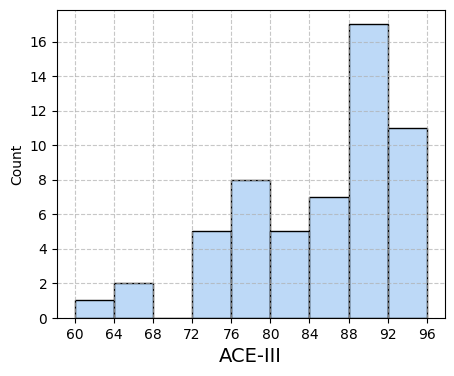

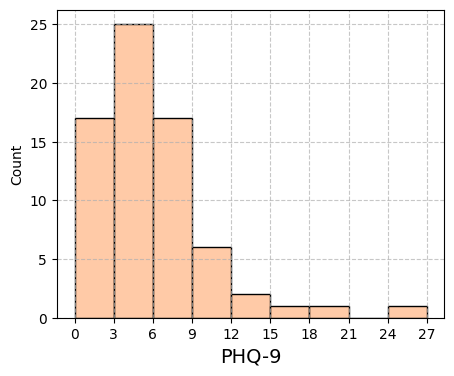

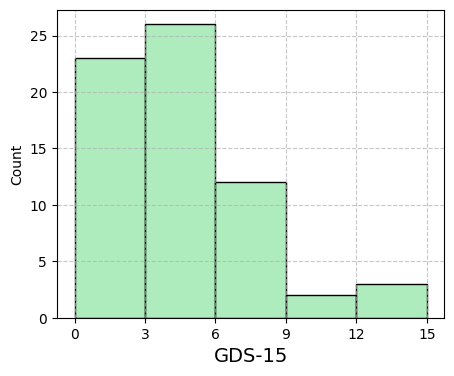

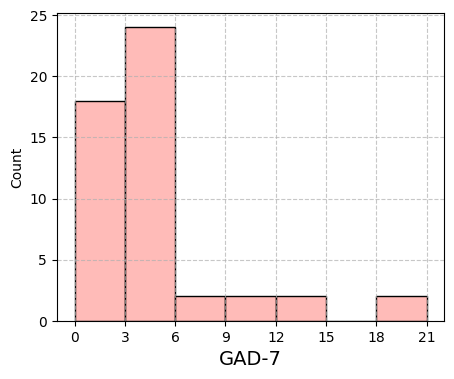

In [20]:
## Plot histograms of 
range_dict = {'ace_total':(60,96,10),'phq_total':(0,27,10),'gds15_total':(0,15,6),'gad_total':(0,21,8)}
ass_names = {"ace_total":"ACE-III","phq_total":"PHQ-9","gds15_total":"GDS-15","gad_total":"GAD-7"}
colors = sns.color_palette("pastel", n_colors=4)
for n,col in enumerate(['ace_total','phq_total','gds15_total','gad_total']):
    plt.figure(figsize=(5, 4))
    values = demographic[col].values.astype(int)
    values = values[values>0]
    bin_edges = np.linspace(range_dict[col][0], range_dict[col][1], num=range_dict[col][2])
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    sns.histplot(values, bins=bin_edges, alpha=0.7,color=colors[n])

    plt.xlabel(ass_names[col],fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks([bin_edges[i] for i in range(len(bin_edges))])
    plt.savefig('../figures/hist_'+col+'.pdf',bbox_inches='tight')

## Visualize the number of participants in the study along time axis

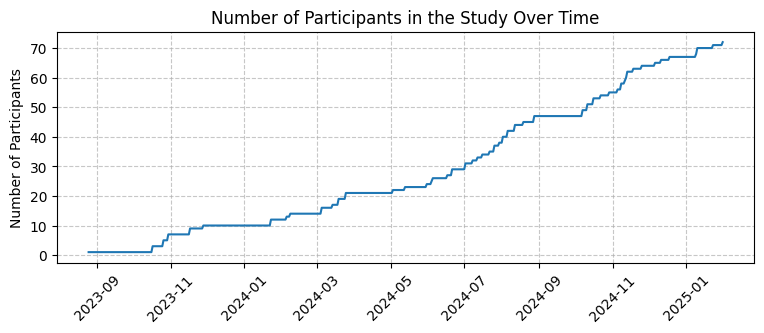

In [21]:

demographic['phq_date']=pd.to_datetime(demographic['phq_date'])

# Group by join date to count new users per day
daily_users = demographic.groupby('phq_date').size().reset_index(name='new_users')

# Create a continuous date range covering the entire study period
date_range = pd.date_range(start=demographic['phq_date'].min(), end=demographic['phq_date'].max())

# Build a DataFrame with the full date range and merge with the new users data
daily_users_full = pd.DataFrame({'phq_date': date_range})
daily_users_full = daily_users_full.merge(daily_users, on='phq_date', how='left')
daily_users_full['new_users'] = daily_users_full['new_users'].fillna(0)

# Compute the cumulative number of users over time
daily_users_full['cumulative_users'] = daily_users_full['new_users'].cumsum()

# Plot the cumulative number of users
plt.figure(figsize=(9, 3))
plt.plot(daily_users_full['phq_date'], daily_users_full['cumulative_users'], 
          linestyle='-')
# plt.xlabel('Date')
plt.ylabel('Number of Participants')
plt.title('Number of Participants in the Study Over Time')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.savefig('../figures/num_participants.svg',bbox_inches='tight')

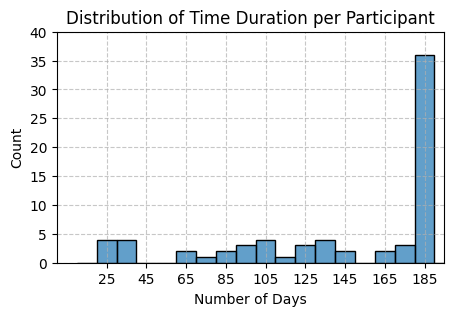

In [48]:
user_durations = all_users_daily.groupby('user_id')['date'].agg(lambda x: x.nunique())
plt.figure(figsize=(5, 3))
bin_edges = np.linspace(10, 200, num=20)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

sns.histplot(user_durations.values, bins=bin_edges, alpha=0.7)

plt.xlabel('Number of Days')
plt.ylim(0,40)
plt.xlim(0,195)
plt.title('Distribution of Time Duration per Participant')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([bin_centers[i] for i in range(len(bin_centers)) if i%2==1])
plt.savefig('../figures/overview_days.svg',bbox_inches='tight')

## Visualize variable distributions by sex groups

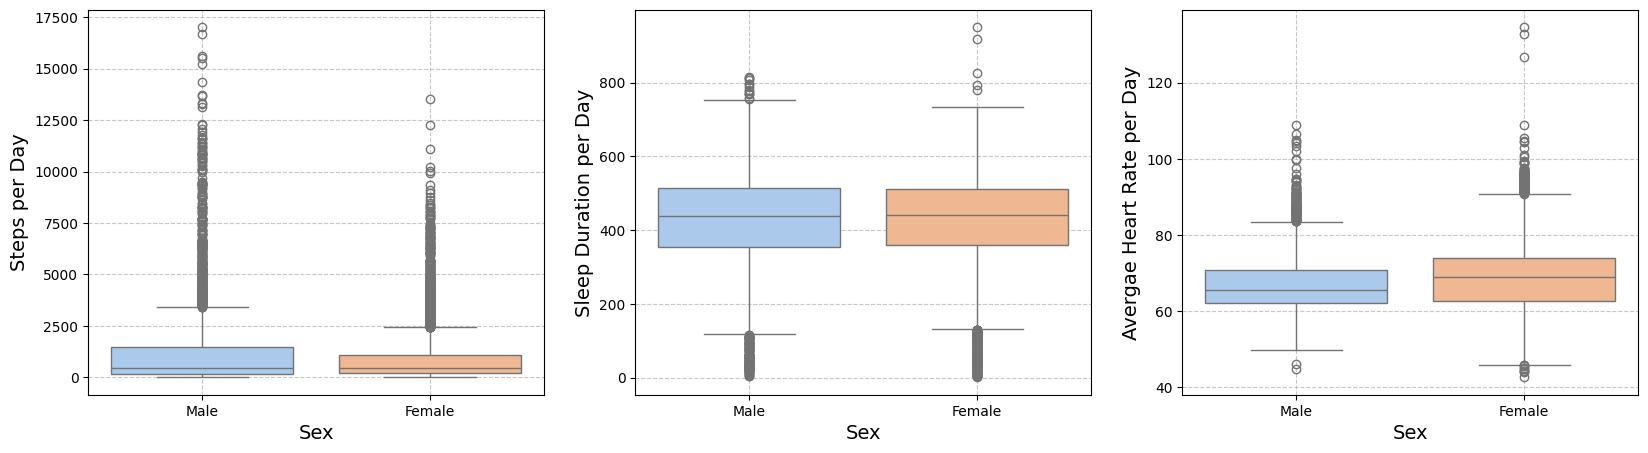

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.boxplot(x='Sex', y='Watch_Steps', data=all_users_daily, ax=axes[0], palette="pastel")
sns.boxplot(x='Sex', y='sleep_duration', data=all_users_daily, ax=axes[1], palette="pastel")
sns.boxplot(x='Sex', y='Watch_Heart Rate_mean', data=all_users_daily, ax=axes[2], palette="pastel")

axes[0].set_xlabel("Sex",fontsize=14)
axes[0].set_ylabel("Steps per Day",fontsize=14)
axes[0].grid(True, linestyle='--', alpha=0.7)

axes[1].set_xlabel("Sex",fontsize=14)
axes[1].set_ylabel("Sleep Duration per Day",fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.7)

axes[2].set_xlabel("Sex",fontsize=14)
axes[2].set_ylabel("Avergae Heart Rate per Day",fontsize=14)
axes[2].grid(True, linestyle='--', alpha=0.7)

cols = ['Steps','Sleep','HR']
for i, ax in enumerate(axes):
    tight_bbox = ax.get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())
    fig.savefig("../figures/sex_"+cols[i]+".pdf", bbox_inches=tight_bbox)

## Visualize Correlations between assessments and sleep states in a given time window

In [25]:
def filter_sleep_data(sleep_daily, uid, ass_date, time_window):
    """ Extract sleep data within the specified time window for a user. """
    ass_date = pd.to_datetime(ass_date)
    sleep_range = sleep_daily.loc[
        (sleep_daily.user_id == uid) &
        (sleep_daily.date > ass_date.date()) &
        (sleep_daily.date <= (ass_date + pd.Timedelta(days=time_window)).tz_localize('UTC').date())
    ]

    return sleep_range

In [26]:
def compute_sleep_statistics(sleep_range,sleep_stats):
    """ Compute average and standard deviation of sleep metrics. """
    if sleep_range.empty:
        return None, None

    sleep_avg = sleep_range[sleep_stats].mean(axis=0)
    sleep_std = sleep_range[sleep_stats].std(axis=0)
    
    return sleep_avg, sleep_std

In [27]:
def process_single_record(i, uid, sleep_daily, score_summary, ass_cols,sleep_stats):
    """ Process a single record: extract sleep data and fill statistics. """
    
    sleep_avg_cols = [st + "_avg" for st in sleep_stats]
    sleep_std_cols = [st + "_std" for st in sleep_stats]
    ass_date = score_summary.loc[score_summary.user_id == uid, ass + "_date"].values[0]
    sleep_range = filter_sleep_data(sleep_daily, uid, ass_date, time_window)
    sleep_avg, sleep_std = compute_sleep_statistics(sleep_range,sleep_stats)

    if sleep_avg is None:
        print(f"No matched time window: {uid}, {len(sleep_range)}")
        return None  # Skip this record if no sleep data is found

    matched_row = {"user_id": uid}
    matched_row.update(score_summary.loc[score_summary.user_id == uid, ["user_id"] + ass_cols].iloc[0].to_dict())
    matched_row.update(dict(zip(sleep_avg_cols, sleep_avg.values)))
    matched_row.update(dict(zip(sleep_std_cols, sleep_std.values)))

    return matched_row

In [28]:
def compute_correlations(ass, ass_sleep_corr, time_window,sleep_stats,file_name='sleep'):
    """ Computes and saves correlations across time windows. """
    sleep_avg_cols = [st + "_avg" for st in sleep_stats]
    sleep_std_cols = [st + "_std" for st in sleep_stats]
    ass_sleep_corr = np.vstack(ass_sleep_corr)

    ass_sleep_corr_df = pd.DataFrame(ass_sleep_corr, columns=[ass.upper()] + sleep_avg_cols + sleep_std_cols)
    return ass_sleep_corr_df

In [29]:
def get_assessment_columns(score_summary, ass):
    """ Retrieve assessment columns matching the given type and suffix. """
    return [c for c in score_summary.columns if ass in c and ('total' in c)]

def match_sleep_assessment(ass, score_summary, sleep_daily, time_window,sleep_stats,file_name='sleep'):
    """ Processes a single assessment type across different time windows. """
    ass_sleep_corr = []
    sleep_avg_cols = [st + "_avg" for st in sleep_stats]
    sleep_std_cols = [st + "_std" for st in sleep_stats]

    ass_cols = get_assessment_columns(score_summary, ass)
    uids = score_summary.user_id.unique()
    print(ass_cols,sleep_stats)
    matched_rows = []
    for i, uid in enumerate(uids):
        matched_row = process_single_record(i, uid, sleep_daily, score_summary, ass_cols=ass_cols,sleep_stats=sleep_stats)
        if matched_row:
            matched_rows.append(matched_row)

    matched_df = pd.DataFrame(matched_rows)
    matched_df.replace([np.inf, -np.inf], np.nan, inplace=True)

    ass_sleep_corr.append(matched_df[ass_cols + sleep_avg_cols + sleep_std_cols].values)

    return compute_correlations(ass, ass_sleep_corr, time_window,sleep_stats,file_name)

In [30]:
# Sleep statistics and column names
sleep_stats = ["wakeup", "light", "deep", "REM"]


# Assessment categories and time windows
assessments = ["phq", "gad", "gds","ace"]
time_window = 7
ass_sleep_corr_map = []
# Run processing for all assessments
for ass in assessments:
    corr_map = match_sleep_assessment(ass, demographic, all_users_daily, time_window,sleep_stats)
    ass_sleep_corr_map.append(corr_map.corr()[ass.upper()])

ass_sleep_corr_map = pd.concat(ass_sleep_corr_map,axis=1).drop([a.upper() for a in assessments],axis=0)

['phq_total'] ['wakeup', 'light', 'deep', 'REM']
No matched time window: 3fdba35f, 0
No matched time window: 7077831c, 0
No matched time window: e29c9c18, 0
No matched time window: 31489056, 0
No matched time window: c837649c, 0
No matched time window: 6208ef0f, 0
['gad_total'] ['wakeup', 'light', 'deep', 'REM']
No matched time window: 3fdba35f, 0
No matched time window: 7077831c, 0
No matched time window: e29c9c18, 0
No matched time window: 811786ad, 0
No matched time window: 31489056, 0
No matched time window: c837649c, 0
No matched time window: 6208ef0f, 0
['gds15_total'] ['wakeup', 'light', 'deep', 'REM']
No matched time window: 3fdba35f, 0
No matched time window: 7077831c, 0
No matched time window: e29c9c18, 0
No matched time window: 31489056, 0
No matched time window: c837649c, 0
No matched time window: 6208ef0f, 0
['ace_total'] ['wakeup', 'light', 'deep', 'REM']
No matched time window: 93e3d8c5, 0
No matched time window: 51841482, 0
No matched time window: df4f4518, 0
No matched

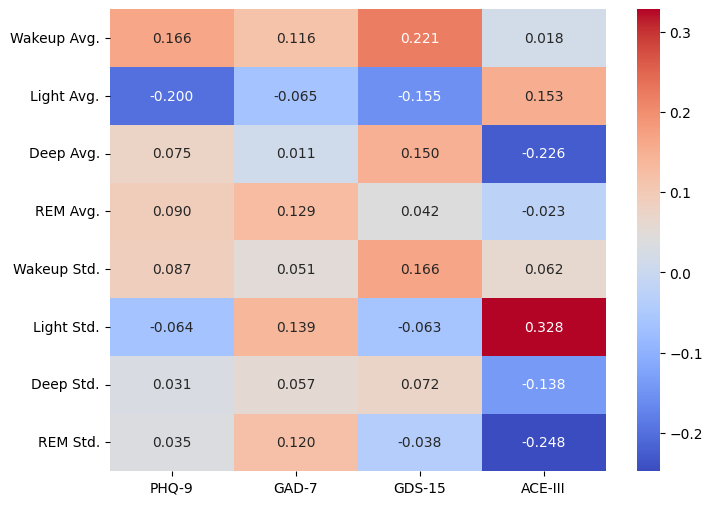

In [31]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(ass_sleep_corr_map,cmap='coolwarm',annot=True, fmt=".3f")
ax.set_xticklabels(['PHQ-9','GAD-7','GDS-15','ACE-III'])
ax.set_yticklabels(['Wakeup Avg.','Light Avg.','Deep Avg.','REM Avg.','Wakeup Std.','Light Std.','Deep Std.','REM Std.'])
plt.savefig("../figures/sleep"+'_'+str(time_window)+"d_assess_corr_map.pdf",bbox_inches='tight')

## Visualize Correlations between assessments and watch data in a given time window

In [33]:
# Sleep statistics and column names
watch_act = ['Watch_Heart Rate_mean', 'Watch_Heart Rate_min', 'Watch_Heart Rate_max', 'Watch_Steps']


# Assessment categories and time windows
assessments = ["phq", "gad", "gds","ace"]

time_window = 7
ass_sleep_corr_map = []
# Run processing for all assessments
for ass in assessments:
    corr_map = match_sleep_assessment(ass, demographic, all_users_daily, time_window,watch_act)
    ass_sleep_corr_map.append(corr_map.corr()[ass.upper()])
ass_sleep_corr_map = pd.concat(ass_sleep_corr_map,axis=1).drop([a.upper() for a in assessments],axis=0)

['phq_total'] ['Watch_Heart Rate_mean', 'Watch_Heart Rate_min', 'Watch_Heart Rate_max', 'Watch_Steps']
No matched time window: 3fdba35f, 0
No matched time window: 7077831c, 0
No matched time window: e29c9c18, 0
No matched time window: 31489056, 0
No matched time window: c837649c, 0
No matched time window: 6208ef0f, 0
['gad_total'] ['Watch_Heart Rate_mean', 'Watch_Heart Rate_min', 'Watch_Heart Rate_max', 'Watch_Steps']
No matched time window: 3fdba35f, 0
No matched time window: 7077831c, 0
No matched time window: e29c9c18, 0
No matched time window: 811786ad, 0
No matched time window: 31489056, 0
No matched time window: c837649c, 0
No matched time window: 6208ef0f, 0
['gds15_total'] ['Watch_Heart Rate_mean', 'Watch_Heart Rate_min', 'Watch_Heart Rate_max', 'Watch_Steps']
No matched time window: 3fdba35f, 0
No matched time window: 7077831c, 0
No matched time window: e29c9c18, 0
No matched time window: 31489056, 0
No matched time window: c837649c, 0
No matched time window: 6208ef0f, 0
['ace

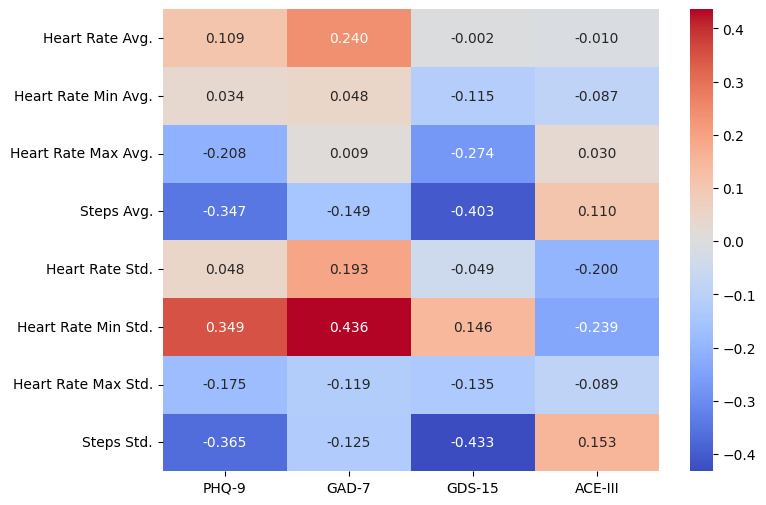

In [34]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(ass_sleep_corr_map,cmap='coolwarm',annot=True, fmt=".3f")
ax.set_xticklabels(['PHQ-9','GAD-7','GDS-15','ACE-III'])
ax.set_yticklabels(['Heart Rate Avg.','Heart Rate Min Avg.','Heart Rate Max Avg.','Steps Avg.','Heart Rate Std.','Heart Rate Min Std.','Heart Rate Max Std.','Steps Std.'])
plt.savefig("../figures/watch"+'_'+str(time_window)+"d_assess_corr_map.pdf",bbox_inches='tight')

## Visualize sleep trajectories of individual participants

In [35]:
def obtain_moving_avg(signal,window_size=7,mode='valid',axis=-1):
    
    # Initialize an array to hold the moving average
    moving_avg = np.empty(signal.shape)
    moving_squared_mean = np.empty(signal.shape)

    # Compute the cumulative average for the initial part
    for i in range(window_size-1):
        moving_avg[...,i] = np.mean(signal[...,:i+1],axis=axis)
        moving_squared_mean[...,i] = np.mean(signal[...,:i+1],axis=axis)**2
        
    # Compute the moving average for the remaining part
    moving_avg[...,window_size-1:] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(window_size)/window_size, mode=mode), axis=axis, arr=signal)

    # Compute rolling squared mean using convolution
    data_squared = signal ** 2
    moving_squared_mean[...,window_size-1:] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(window_size)/window_size, mode=mode), axis=axis, arr=data_squared)
    
    # Calculate rolling standard deviation
    moving_average_squared = moving_avg ** 2
    moving_std = np.sqrt(moving_squared_mean - moving_average_squared)

    return moving_avg, moving_std

In [36]:
def get_user_daily_df(uid):
    tmp = all_users_daily.loc[all_users_daily.user_id==uid]
    if len(tmp)==0:
        print('no sleep data for user id ',uid)
        return
    start_date = tmp['date'].min()
    end_date = start_date + pd.Timedelta(days=185) ## half a year range
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    tmp = tmp[(tmp['date'] >= start_date) & (tmp['date'] < end_date)]
    tmp = tmp.set_index('date')

    tmp_full = tmp.reindex(date_range)
    tmp_full.index.name = 'date'
    return tmp_full,start_date,end_date

In [37]:
def plot_user_sleep_traj(user_id):
    tmp_full,start_date,end_date = get_user_daily_df(user_id)
    if tmp_full is None:
        return
    
    sleep_cols = ['light','deep','REM','wakeup']
    moving_avg = obtain_moving_avg(tmp_full[sleep_cols].values.transpose(),window_size=7,mode='valid',axis=-1)
   
    fig,ax=plt.subplots(figsize=[20,4])
    ax.plot(tmp_full.index,moving_avg[0][0],linewidth=3)
    ax.plot(tmp_full.index,moving_avg[0][1],linewidth=3)
    ax.plot(tmp_full.index,moving_avg[0][2],linewidth=3)
    ax.plot(tmp_full.index,moving_avg[0][3],linewidth=3)
    ax.set_ylim(0,600)
    ax.set_xlim(start_date- pd.Timedelta(days=1),end_date+ pd.Timedelta(days=0))
    tick_dates = [start_date+relativedelta(months=1*n) for n in range(0,7)]
    ax.set_xticks(tick_dates)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    
    scores = ["ace_","phq_","gds15_","gad_"]
    # Add vertical lines and annotations
    days_offset = 0
    sfx = "baseline"
        
    vline_date = start_date + pd.Timedelta(days=days_offset)
    for tdt in tick_dates:
        ax.axvline(tdt, color="red", linestyle="--", linewidth=1)

    
    ax.text(vline_date, 580, f" ACE-III:{demographic.loc[demographic.user_id==uid,scores[0]+'total'].values[0]}\n PHQ-9: {demographic.loc[demographic.user_id==uid,scores[1]+'total'].values[0]} \n GDS-15: {demographic.loc[demographic.user_id==uid,scores[2]+'total'].values[0]} \n GAD-7: {demographic.loc[demographic.user_id==uid,scores[3]+'total'].values[0]}",  
                color="red", fontsize=15, rotation=0, verticalalignment='top')
    

    ax.set_title("UID: "+uid,fontsize=15)
    ax.legend(['light','deep','REM','wakeup'],loc=[.88,0.56],fontsize=16)
    plt.savefig("../figures/sleep_vis_"+user_id+".svg",bbox_inches="tight")
    plt.show()
    plt.close()

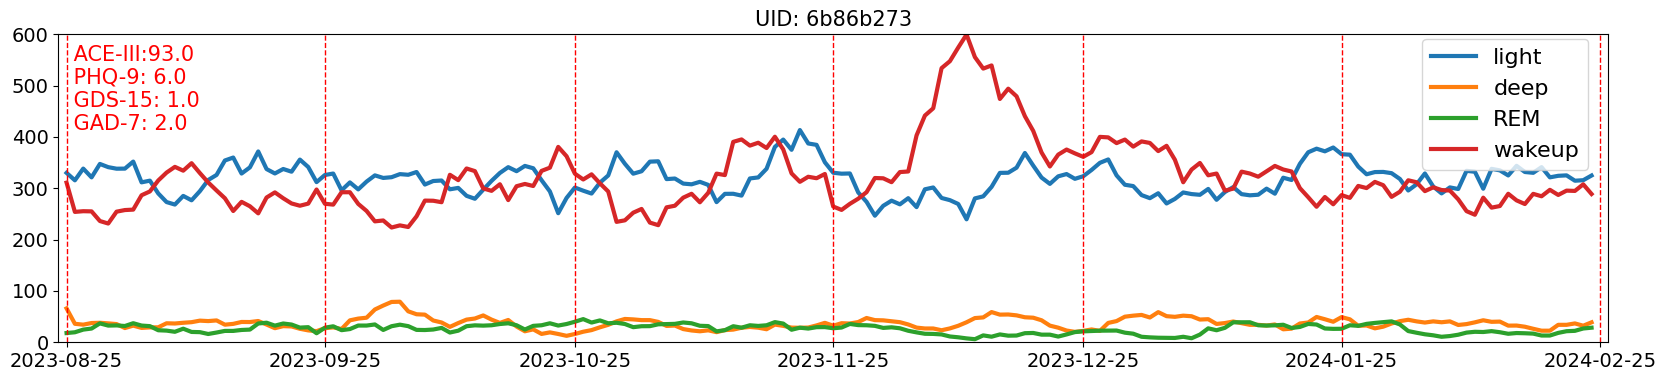

In [38]:
uid = '6b86b273'
plot_user_sleep_traj(uid)

## Visualize steps trajectory for invidual participants

In [39]:
def plot_user_steps_traj(uid):
    tmp = all_users_daily.loc[all_users_daily.user_id==uid]
    if len(tmp)==0:
        print('no sleep data for user id ',uid)
        return
    start_date = tmp['date'].min()
    end_date = start_date + pd.Timedelta(days=185)
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    tmp = tmp[(tmp['date'] >= start_date) & (tmp['date'] < end_date)]
    tmp = tmp.set_index('date')

    tmp_full = tmp.reindex(date_range)
    tmp_full.index.name = 'date'
    
    moving_avg = obtain_moving_avg(tmp_full['Watch_Steps'].values.transpose(),window_size=7,mode='valid',axis=-1)


    fig,ax=plt.subplots(figsize=[20,4])
    ax.plot(tmp_full.index,moving_avg[0],linewidth=3)
    ax.set_xlim(start_date- pd.Timedelta(days=1),end_date+ pd.Timedelta(days=0))
    tick_dates = [start_date+relativedelta(months=1*n) for n in range(0,7)]
    ax.set_xticks(tick_dates)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    
    scores = ["ace_","phq_","gds15_","gad_"]
    days_offset = 0
    sfx = "baseline"
        
    for tdt in tick_dates:
        ax.axvline(tdt, color="red", linestyle="--", linewidth=1)
    
  

    ax.set_title("UID: "+uid,fontsize=15)
    ax.legend(['Steps'],loc=[.88,0.86],fontsize=16)
    plt.savefig("../figures/step_vis_"+uid+".svg",bbox_inches="tight")
    plt.show()
    plt.close()

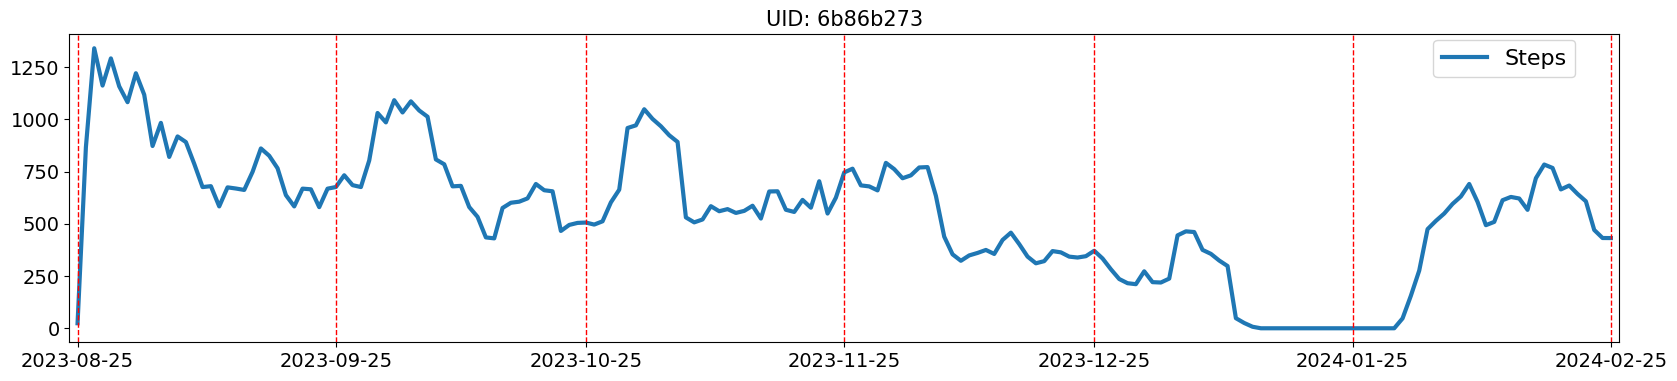

In [40]:
uid = '6b86b273'
plot_user_steps_traj(uid)